In [123]:
# things we want to capture:
# tangible equity/tangible asset -> we need tangible equity and tangible asset 
# leverage ratio, apparently this is diff than tang asset percent
# Also use total debt / total assets == leverage

list_files = os.listdir("./assetsheets")
num_files = len(list_files)
arr = []
for file in list_files:
    file_path = "./assetsheets/" + file
    total_str = ""
    if (os.path.isfile(file_path)):
        with open(file_path,encoding='utf-8') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter='\n')
            for row in csv_reader:
                x = "".join(row)
                total_str += x
    arr.append(total_str)
        
dict_data = {}
for data,bank in zip(arr,list_files):
#     print(data,bank)
    try:
        equity_tang_asset = data.split("Total Shareholders\' Equity / Total Assets")[1].split("Return On Average Total Equity")[0].replace(",","")
        split_eq = equity_tang_asset.split("%")
        last_eq = split_eq[-2]
        total_asset_debt = data.split("Total Debt / Total Assets")[1].split("Deferred Tax")[0].replace(",","")
        split_debt = total_asset_debt.split('%')
        last_tad = split_debt[-2]
        dict_data[bank] = [last_eq,last_tad]
        
            
        
    except:
        # cant find total equity / total assets
        pass
# print(dict_data)

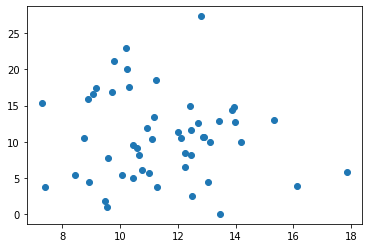

In [124]:
x = []
y = []

for value in dict_data.values():
    x.append(float(value[0]))
    y.append(float(value[1]))
plt.scatter(x,y)

# Below is what we're going to be sorting on gmm.. yikes


In [125]:
df = pd.DataFrame(
    {'eta': x,
     'tdta': y,
    })

Fiscal year is January-December. All values USD Millions.,2022,2021,2020,2019,2018,5-year trend,All values USD Millions.,2022,2021,2020,2019,2018,5-year trendTotal Cash & Due from Banks,556,208,16,2,4,,,,,,,,,,Cash & Due from Banks Growth,166.86%,1169.08%,938.95%,-62.20%,-,,,,,,,,,,,,,,,,,,,Investments - Total,"10,143","14,766","4,797","1,439","1,389",,,,,,,,,,Trading Account Securities,-,-,-,-,-,Federal Funds Sold & Securities Purchased,-,-,-,-,-,Federal Funds Sold,-,-,-,-,-,Securities Bought Under Resale Agreement,-,-,-,-,-,Treasury Securities,-,-,-,-,-,Federal Agency Securities,-,"1,179",-,-,-,,,,,,,,,,State & Municipal Securities,-,"2,695",286,-,-,,,,,,,,,,Mortgage Backed Securities,-,"4,519",407,646,98,,,,,,,,,,Other Securities,-,232,246,252,259,,,,,,,,,,Other Investments,"4,410","6,141","3,858",542,"1,032",,,,,,,,,,Investments Growth,-31.31%,207.85%,233.23%,3.65%,-,,,,,,,,,,,,,,,,,,,Net Loans,408,887,747,665,593,,,,,,,,,,Gross Loans - Net of Unearned Income,-,-,-,-,-,Commercial &

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import os
import csv

In [127]:
def GMM(dat, k):
    
    #Comments will reference slides 26-31 from Feb 9
    
    """Define the variables we will use in the Algorithm"""
    #This represents Σ_m (covariance matrix of each component) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)
    
    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    
    # Use p_data_given_class to derive p_mi for expectation step. 
    p_data_given_class=np.zeros((len(dat),k))
    
    p_class_given_data=np.zeros((len(dat),k))
    

    
    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    # we get k indices of random data points. 
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        # changes rows into columns and columns into rows
        # this rets a 2x2 covariance, we set it for each dimension
        covars[dim,:,:]=np.cov(np.transpose(dat))
        

        #Set initial means to initial chosen data points (slide 26)
        # we just set to some data points we have.
        
        # Remember we picked dim number of random indices. Now we're just getting that random number and setting the means to it
        # the means[dim,:] means setting latitude and longitude
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
    
    """Now Iterate"""
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    #Note - 50 steps is fine, no requirement to check for convergence on this HW
    for step in range(50):
        # we run it 50 times to get to a convergence of our means, covars, etc. for each cluster
        """Expectation Step (Slide 27)"""
        for i in range(len(dat)):
            for dim in range(k):
                x = dat.iloc[i,0]
                y = dat.iloc[i,1]
    
                # gives us unnormalized probability of being in each cluster
                pmi = stats.multivariate_normal.pdf(x=(x,y), mean=means[dim], cov=covars[dim,:,:], allow_singular=True)
                p_data_given_class[i][dim] = pmi*p_class[dim]

        # normalize them now
        for i in range(len(dat)):
            summ = sum(p_data_given_class[i])
            for dim in range(k):
                p_class_given_data[i][dim] = p_data_given_class[i][dim]/summ

        
        """Maximization Step (Slide 29-30)"""
        
        new_weights = p_class=np.zeros(k)
        new_means = np.zeros((k,2))
        new_covars = np.zeros((k,2,2))
        for dim in range(k):
            nm = 0
            x_mean_sum = 0
            y_mean_sum = 0
            x_covar = 0
            y_covar = 0
            covar_new = np.zeros((2,2))
            for i in range(len(dat)):
                nm += p_class_given_data[i][dim]
                x_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,0])
                y_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,1])
                
            # change weights
            new_weights[dim] = nm/len(dat)
            # change means using nm and mean_sum's calc'd above
            new_means[dim] = [(x_mean_sum/nm),(y_mean_sum/nm)]
            total = np.zeros((2, 2))
            for j in range(len(dat)):
                total += p_class_given_data[j, dim] * np.outer(list(dat.iloc[j,:]) - means[dim], list(dat.iloc[j,:]) - means[dim])
            covars[dim] = total / nm
        
            
        # set all of our new vars
        means = new_means
        p_class = new_weights
            

    """Once we're done with our for loop, we compute the mean dist (This formula is given in the HW below in Part B)"""
    sum_iter = 0
    for i in range(len(dat)):
        for m in range(k):
            pmi = p_class_given_data[i][m]
            # need to weight points that are closer to mean higher>
            dist_x = (dat.iloc[i,0]-means[dim][0])**2
            dist_y = (dat.iloc[i,1]-means[dim][1])**2
#             sum_iter += (comb*(dist_y))
#             sum_iter += (comb*(dist_y))
    n = len(dat)
    mean_dist = (sum_iter/n)**1/2
    

    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist



In [130]:
p_class_given_data_lst = []
means_lst = []
covars_lst = []
p_class_lst = []
mean_dist_lst = []


for i in range(1,9):
    print("Testing for K: " + str(i))
    p_class_given_data, means, covars, p_class, mean_dist = GMM(df, i)
    p_class_given_data_lst.append(p_class_given_data)
    means_lst.append(means)
    covars_lst.append(covars)
    p_class_lst.append(p_class)
    mean_dist_lst.append(mean_dist)


Testing for K: 1
Testing for K: 2
Testing for K: 3
Testing for K: 4
Testing for K: 5
Testing for K: 6
Testing for K: 7
Testing for K: 8


Text(0, 0.5, 'mean distance')

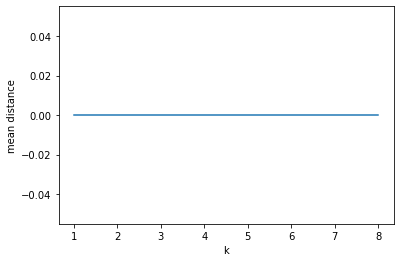

In [131]:
plt.plot(range(1,9),mean_dist_lst)
plt.xlabel("k")
plt.ylabel("mean distance")

In [140]:
dict_pts = {}
for idx,data in enumerate(p_class_given_data_lst[-3]):
    lst = list(data)
    max_value = max(lst)
    index = lst.index(max_value)
    our_point = df.iloc[idx,:]
    our_point_lst = list(our_point)
    if index not in dict_pts:
        dict_pts[index] = [our_point_lst]
    else:
        dict_pts[index].append(our_point_lst)

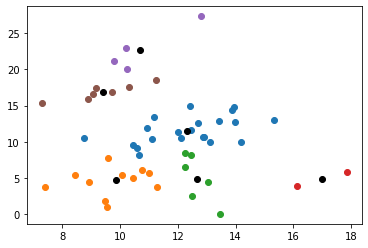

In [141]:

for key, value in dict_pts.items():
    x = [i[0] for i in dict_pts[key]]
    y = [i[1] for i in dict_pts[key]]
    plt.scatter(x,y)
plt.scatter([i[0] for i in means_lst[-3]], [i[1] for i in means_lst[-3]], color="black")